# Lecture 1 - Data Preprocessing

There are two basic goals of data processing:

* Improve the quality of the data to ensure reliable/meaningful/expressive results
* Prepare the data to be a valid input for the algorithms applied during the analysis (for example, most algorithms cannot handle string values)

Which steps to perform during data preprocessing is to a large extent informed by the results of the Exploratory Data Analysis (EDA).

## Setting up the notebook

Specify how plots get rendered

In [1]:
%matplotlib notebook

Make all required imports

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Loading the Data

The dataset is directly taken from Kaggle (but messed up to make it more interesting; see the EDA notebook). You can check the following long for more details about the dataset, particularly the documentation of the different attributes and attribute ranges:

https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

In [3]:
df = pd.read_csv('data/cardio_train_messy.csv', sep=';')

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0.0,18393.0,2.0,168.0,62.0,110.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,20228.0,1.0,156.0,85.0,140.0,90.0,3.0,1.0,0.0,0.0,1.0,1.0
2,2.0,18857.0,1.0,165.0,64.0,130.0,70.0,3.0,1.0,0.0,0.0,0.0,1.0
3,3.0,17623.0,2.0,169.0,82.0,150.0,100.0,1.0,1.0,0.0,0.0,1.0,1.0
4,4.0,17474.0,1.0,156.0,0.0,100.0,60.0,1.0,1.0,0.0,0.0,0.0,0.0


In [4]:
num_points, num_attributes = df.shape

print("There are {} data points, each with {} attributes.". format(num_points, num_attributes))

There are 70000 data points, each with 13 attributes.


Data preprocessing steps might involve removing data points and/or attributes. So it can be useful to keep an eye on that. Particularly problematic would be if we would remove the majority of data points. This can mean that we did something wrong and should think harder, or the dataset is really that bad to make it unusable.

## Data Cleaning

### Handle Missing Values

#### NA values

If there are not too many data points with NA values for some attributes, it's often the most straightforward way to simple remove such data points. Replacing/filling NA values is not always applicable and generally make some assumptions that must hold.

The simplest way to remove all rows from a data frame that have NA values is with the [`pandas.DataFrame.dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html). So we could do

In [5]:
df_dropna_all = df.dropna()

num_points, num_attributes = df_dropna_all.shape

print("There are {} data points, each with {} attributes.". format(num_points, num_attributes))

There are 61404 data points, each with 13 attributes.


However, we don't really care about NA values for attributes we don't need for our analysis. For example, or dataset has and `id` column. This is just an artificial attributes that is not useful. So let's first remove this column, and then remove all rows with NA values

In [6]:
df = df.drop(columns=['id'])

df_dropna_needed = df.dropna()

In [7]:
num_points, num_attributes = df_dropna_needed.shape

print("There are {} data points, each with {} attributes.". format(num_points, num_attributes))

There are 62058 data points, each with 12 attributes.


Not that this removes less data points than doing the removal without removing `id`. Of course, we could and should remove all columns we decided not to use for our analysis. While the difference in this is example is not that great -- since we randomly remove attribute values -- in practice, this can make a big difference.

In [8]:
# Let's continue with the data frame with out the id column
df = df_dropna_needed

#### Default Values

In line with what we already done during the EDA, let's plot the distribution of `weight` values using a simple histogram -- obviously, this should be be done for many to most relevant attributes, since in practice we would know that `weight` has been tampered with.

<IPython.core.display.Javascript object>


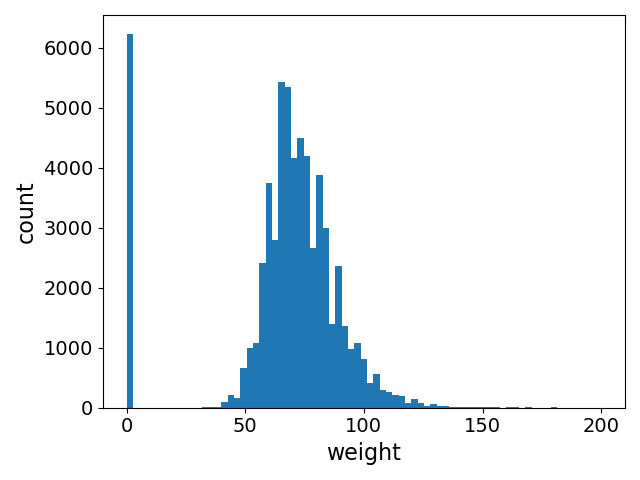

In [9]:
plt.figure()
plt.tick_params(labelsize=14)
plt.hist(df['weight'].to_numpy(), bins=75)
plt.xlabel('weight', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.tight_layout()
plt.show()

In this example, it's relatively easy to see the `weight=0` represents some kind of noisy value. Firstly, it far off the expected distribution, and secondly, we semantically know that a person cannot have a weight of zero.

Let's check how many data points actually have a weight of 0 (this should, of course, match the hight of the bar in previous plot)

In [10]:
print(df[df.weight == 0].shape)

(6234, 12)


So how do we handle this, assuming we cannot simple remove `weight` because we need it for our analysis? The straightforward step is to remove all data points with `weight=0` as follows:

In [11]:
# Keep only the rows where weight != 0
df_no_default = df[df.weight != 0]

In [12]:
num_points, num_attributes = df_no_default.shape

print("There are {} data points, each with {} attributes.". format(num_points, num_attributes))

There are 55824 data points, each with 12 attributes.


Well, we would loose another couple of thousand data points, which seems not too bad. Again, there are no hard rules or thresholds to decide when a loss of data is acceptable or not.

Alternatively, there is the approach to replace missing values -- NA or default values -- with (hopefully) good estimates. The challenge here is to find a meaningful strategy to come up with good estimates. In the following, we use the following simple (over-simplified?) strategy to set the weight of a data point `x` with `weight=0` as follows:

* Find k data points with heights most similar to the height of `x`
* Calculate the median weight of those k data points
* Set `weight` of `x` to the calculated median

This strategy assumes that there is a "reasonably" good correlation between `height` and `weight`.

First, for the calculation of median weights, consider only valid data points (no missing values) for `height` and `weight`. After all, we don't want NA or default values in the list we use to calculate the median.

In [13]:
# Remove rows that have NA values for height or weight
df_valid = df.dropna(subset=['height', 'weight'])

df_valid = df_valid[df_valid.weight != 0]

heights = df_valid['height'].to_numpy()
weights = df_valid['weight'].to_numpy()

print(df_valid.shape)

(55824, 12)


Now we can implement the loop the implements our proposed strategy

In [14]:
# Set k as the number of nearest data points we want to consider
k = 100

# Loop over each data point in our dataset
for idx, row in df.iterrows():
    
    # Print the current row index every 10,000 rows
    # (just some user feedback as this runs a couple of seconds)
    if idx % 10000 == 0:
        print(idx)
    
    # Get the weight and height of the current row
    w, h = row['weight'], row['height']
    
    # If the weight is not the default value 0, do nothing and go to the next row
    if w > 0:
        continue
    
    # Calculate the absolute differences between the current height and all other heights
    # (the data points we are interested in have an absolute difference of 0 or as small as possible)
    diff = np.abs(heights - h)
    
    # Find the k indices with the smallest difference values
    # (these are the k data points with a height most similar to the current row)
    indices = np.argsort(diff)[:k]

    # Select the k weight w.r.t. the the indices
    k_weights = weights[indices]
    
    # Calculate the median of the k selected weights
    # np.mean(k_weights) is a valid and maybe even better alternative (it's a design decision)
    median = np.median(k_weights)
    
    # Set the weight value of the current row to the median
    df.at[idx, 'weight'] = median

0
10000
20000
30000
40000
60000


Let's see how many rows with `weight=0` there are now:

In [15]:
print(df[df.weight == 0].shape)

(0, 12)


The result should be `(0, 12)` indicating that the data frame has 0 rows

We can also plot the distribution of the values for `weight` again:

<IPython.core.display.Javascript object>


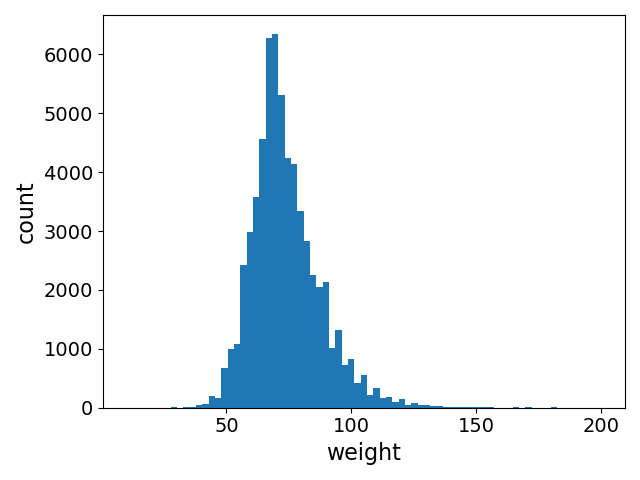

In [16]:
plt.figure()
plt.tick_params(labelsize=14)
plt.hist(df['weight'].to_numpy(), bins=75)
plt.xlabel('weight', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.tight_layout()
plt.show()

In general, replacing missing values with estimates always relies on some assumptions about the data. As we do not know the true values, we can never evaluate how good our estimates are. The hope is that the underlying assumptions to generate the estimates are "reasonable enough" that any potential errors in the estimates are still preferable compared to simply removing the data points.

**Note:** Sometimes, find good estimates is trivial. For example, assume a dataset contains a persons birth date as well as the age. Even if `age` has missing values, they can directly be derived from the values for `birth_date`.

## Data Transformation

### Aggregation

Let's convert `age` from days to years, which aggregates all values to the same one, if they yield the same year

In [17]:
df.age = np.round(df.age / 365)

df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.0,2.0,168.0,62.0,110.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0
1,55.0,1.0,156.0,85.0,140.0,90.0,3.0,1.0,0.0,0.0,1.0,1.0
2,52.0,1.0,165.0,64.0,130.0,70.0,3.0,1.0,0.0,0.0,0.0,1.0
3,48.0,2.0,169.0,82.0,150.0,100.0,1.0,1.0,0.0,0.0,1.0,1.0
4,48.0,1.0,156.0,67.0,100.0,60.0,1.0,1.0,0.0,0.0,0.0,0.0


### Binning & Smoothing



To easier see the effect of Binning & Smoothing, let's look at the data points with lowest values for height.

In [18]:
df.sort_values(by=['height']).head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
22723,64.0,1.0,22.0,81.0,130.0,90.0,1.0,1.0,0.0,0.0,1.0,1.0
64115,50.0,1.0,23.0,57.6,125.0,67.0,1.0,1.0,0.0,0.0,0.0,0.0
29157,52.0,1.0,24.0,69.0,110.0,70.0,1.0,1.0,0.0,0.0,0.0,0.0
27603,57.0,1.0,25.0,61.0,130.0,70.0,1.0,1.0,0.0,0.0,1.0,0.0
50789,40.0,2.0,26.0,60.0,110.0,80.0,1.0,1.0,1.0,1.0,1.0,0.0


Let's bin & smooth `height`, with a small bin size of 3 just to keep it simple

In [19]:
# Convert all heights into a numpy data from
heights = df['height'].to_numpy()

# Get the indices w.r.t to the sorting of the heights
# (e.g., indices[0] is the index of the data point with the smallest height)
indices = np.argsort(heights)

[`numpy.array_split`](https://numpy.org/doc/stable/reference/generated/numpy.array_split.html) is a useful function to split a given array into chunks of the same length (apart from maybe the last chunk)

In [20]:
# Set the bin size
bin_size = 3

# Define an array containing all zeros to hold the new weight values
new_heights = np.zeros_like(heights)

for b in np.array_split(indices, len(indices) // bin_size):
    # Get all the weights w.r.t. to the current bin indices
    bin_heights = heights[b]
    
    # Calucate median (again, mean/average is a valid alternative)
    median = np.median(bin_heights)
    
    # Set the height of ALL the data points in the bin to the median
    new_heights[b] = median


No we only have to set the `weight` attribute to the new list of weights

In [21]:
df.height = new_heights

We can see the differen immediately when looking at the same sample as above

In [22]:
df.sort_values(by=['height']).head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
29157,52.0,1.0,23.0,69.0,110.0,70.0,1.0,1.0,0.0,0.0,0.0,0.0
22723,64.0,1.0,23.0,81.0,130.0,90.0,1.0,1.0,0.0,0.0,1.0,1.0
64115,50.0,1.0,23.0,57.6,125.0,67.0,1.0,1.0,0.0,0.0,0.0,0.0
27603,57.0,1.0,26.0,61.0,130.0,70.0,1.0,1.0,0.0,0.0,1.0,0.0
16699,54.0,2.0,26.0,98.0,140.0,90.0,1.0,1.0,0.0,0.0,1.0,1.0


Compare the output with the one before the binning. Using a bin size of 3 and the median makes understanding the effects very easy in here. For example, while initially the smallest weight values were 28, 32 and 43, they now all now the median of this set, i.e., 32.

### Normalization

Normalizing attribute values ensures that attributes with very different orders of magnitudes are better comparable. Example: height is measuresd in meters (e.g., 0.25m to 2.5m) and weight is measures in grams (e.g., 20,000g to 200,000g).

This can be a problem for many data mining algorithms that rely of calculating the distance between data points such as clustering.

In the following, we normalize both `weight` and `height`, although we already applied Binning & Smoothing to `height`. Of nothing, nothing is stopping as to do so, but in practice such design decision need to be justified.

#### Standardization

Standardization or z-score normalization assumes that the attribute values a (roughly) normally distributed. The standardized value (z-score) reflects the relative distance of the original attribute value to the overall mean. Accordingly, the formula for the calculation is given a attribute value $x_i$ is:

$$z_i  =\frac{x_i - \mu}{\sigma}$$

where $\mu$ is the mean and $\sigma$ is the standard variation over all attribute values in the dataset.

Using `pandas` and `numpy` we can implement this for `weight` and `height` very easily. Note that we don't need a loop that goes over each data point.

In [23]:
df['weight'] = (df['weight']-df['weight'].mean()) / df['weight'].std()
df['height'] = (df['height']-df['height'].mean()) / df['height'].std()

In [24]:
df.sort_values(by=['height']).head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
29157,52.0,1.0,-2.994928,-0.362502,110.0,70.0,1.0,1.0,0.0,0.0,0.0,0.0
22723,64.0,1.0,-2.994928,0.508510,130.0,90.0,1.0,1.0,0.0,0.0,1.0,1.0
64115,50.0,1.0,-2.994928,-1.189963,125.0,67.0,1.0,1.0,0.0,0.0,0.0,0.0
27603,57.0,1.0,-2.920951,-0.943177,130.0,70.0,1.0,1.0,0.0,0.0,1.0,0.0
16699,54.0,2.0,-2.920951,1.742444,140.0,90.0,1.0,1.0,0.0,0.0,1.0,1.0


We can check the standardization step by calculating the new means for `weight` and `height`.

In [25]:
mean_weight = np.mean(df['weight'])
mean_height = np.mean(df['height'])

print('Mean of weight: {}'.format(mean_weight))
print('Mean of height: {}'.format(mean_height))

Mean of weight: -1.0639744659846956e-15
Mean of height: 1.4599026668843867e-16


Apart from issues with floating point precision, both means should be zero.

#### Scaling using Min-Max Normalization

Min-Max normalization scales all attribute values into a specified range. For a range of [0,1], the formula is as follows:

$$x^{norm}_i =\frac{x_i - MIN}{MAX - MIN} $$ 

where $MIN$ is the minimum and $MAX$ is the maximum among all attribute values. As a result, the smallest value gets scaled to 0, and the largest value gets scaled to 1.

**Note:** In this example, we scale after standardizing. In practice, you would choose only of the the methods

In [26]:
df['weight'] = (df['weight']-df['weight'].min()) / (df['weight'].max()-df['weight'].min())
df['height'] = (df['height']-df['height'].min()) / (df['height'].max()-df['height'].min())

In [27]:
df.sort_values(by=['height']).head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
29157,52.0,1.0,0.000000,0.310526,110.0,70.0,1.0,1.0,0.0,0.0,0.0,0.0
22723,64.0,1.0,0.000000,0.373684,130.0,90.0,1.0,1.0,0.0,0.0,1.0,1.0
64115,50.0,1.0,0.000000,0.250526,125.0,67.0,1.0,1.0,0.0,0.0,0.0,0.0
27603,57.0,1.0,0.017143,0.268421,130.0,70.0,1.0,1.0,0.0,0.0,1.0,0.0
16699,54.0,2.0,0.017143,0.463158,140.0,90.0,1.0,1.0,0.0,0.0,1.0,1.0


Note that the smallest height values are now 0.

### Discretization

Discretization converts continuous  attributes into ordinal one. Some algorithms only accept categorical attributes or might perform better when the data values are "simplified" in a meaningful manner.

To keep this example simple and more illustrative, let's use the original dataset without any missing value etc. We also ignore a whole bunch of columns to make the representation easier

In [28]:
df = pd.read_csv('data/cardio_train.csv', sep=';')

df = df.drop(columns=['height', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'])

df.head()

,id,age,gender,weight
0,0,18393,2,62.0
1,1,20228,1,85.0
2,2,18857,1,64.0
3,3,17623,2,82.0
4,4,17474,1,56.0


Let's assume we want to discretize `weight` into three classes `light`, `average` and `heavy`

In [29]:
labels = ['light', 'average', 'heavy']

`pandas` has nifty methods to map numeric values to predefined intervals; check [`pandas.IntervalIndex.from_tuples`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.IntervalIndex.from_tuples.html) and [`pandas.cut`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html)

In [30]:
# For our this example, let's consider 
# weights between 0 and 70 == light,
# weights between 70 and 90 == average,
# weights between 90 and 999 == heavy (999 just represents a max upper boundary)
bins = pd.IntervalIndex.from_tuples([(0, 70), (70, 90), (90, 999)])

# Create a new colum weight_interval
df['weight_interval'] = pd.cut(df['weight'], bins=bins)

df.head()

,id,age,gender,weight,weight_interval
0,0,18393,2,62.0,"(0, 70]"
1,1,20228,1,85.0,"(70, 90]"
2,2,18857,1,64.0,"(0, 70]"
3,3,17623,2,82.0,"(70, 90]"
4,4,17474,1,56.0,"(0, 70]"


We can now map this 3 different intervals to our 3 weight labels; again, `pandas` has handy methods for this.

In [31]:
# Connect the 3 bins with the 3 labels
d = dict(zip(bins,['light','average','heavy']))

# Create a new column weight_class
df['weight_class'] = pd.cut(df['weight_interval'],bins).map(d)

df.head()

,id,age,gender,weight,weight_interval,weight_class
0,0,18393,2,62.0,"(0, 70]",light
1,1,20228,1,85.0,"(70, 90]",average
2,2,18857,1,64.0,"(0, 70]",light
3,3,17623,2,82.0,"(70, 90]",average
4,4,17474,1,56.0,"(0, 70]",light


Lastly, we can remove the original attribute `weight` and the auxiliary attribute `weight_interval`

In [32]:
df = df.drop(columns=['weight', 'weight_interval'])

df.head()

,id,age,gender,weight_class
0,0,18393,2,light
1,1,20228,1,average
2,2,18857,1,light
3,3,17623,2,average
4,4,17474,1,light


### One-Hot Encoding

We can use One-Hot Encoding (or similar: Dummy Encoding) to convert categorical attributes into numerical ones attributes. Let's use the previous output and encode `weight_class`. This is a very common preprocessing step since many algorithms do not support categorical attributes.

We can use [`pandas.get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) for that to make it very easy for us.

In [33]:
weight_class_dummies = pd.get_dummies(df.weight_class, prefix='weight_class')

weight_class_dummies

,weight_class_light,weight_class_average,weight_class_heavy
0,1,0,0
1,0,1,0
2,1,0,0
3,0,1,0
4,1,0,0
...,...,...,...
69995,0,1,0
69996,0,0,1
69997,0,0,1
69998,0,1,0


Now we only have to replace the `weight_class` attribute with the new dummy attributes.

In [34]:
# Concatenate inital data frame with dummy data frame
df = pd.concat([df, weight_class_dummies], axis=1)

# Remove the weight_class column
df = df.drop(columns=['weight_class'])

df.head()

,id,age,gender,weight_class_light,weight_class_average,weight_class_heavy
0,0,18393,2,1,0,0
1,1,20228,1,0,1,0
2,2,18857,1,1,0,0
3,3,17623,2,0,1,0
4,4,17474,1,1,0,0


## Summary

Data preprocessing is a very important and often required step to improve data quality and to create a valid input for subsequently applied algorithms. Therefore, which data preprocessing steps to perform depends on the task but also on a solid understanding of the data, which in turn should be the result of the EDA. In this notebook -- and in the course of this module -- the main focus is in datasets in form of records (e.g., structured data). However, data preprocessing is also crucial for unstructured data such as text, images, or videos.

Data preprocessing -- particularly transformation steps like Binning & Smoothing, Discretization or Aggregation -- modify the data. This generally results in some loss of information. Thus, the expected of such data processing steps need to be justified or even evaluated (e.g., by comparing the results with and without the application of certain methods).